# 04 - Skill Demand Prediction Model

This notebook builds an ML model to predict whether each skill's demand will be **hot**, **stable**, or **declining** in the next quarter.

**Approach:**
1. Aggregate monthly skill demand from job postings
2. Engineer temporal + metadata + embedding features
3. Train `HistGradientBoostingClassifier` (classification) + `HistGradientBoostingRegressor` (ranking)
4. Evaluate against baselines with time-series cross-validation
5. Handle cold-start skills via embedding similarity
6. Export predictions for backend API consumption

**Inputs:** Processed parquet files from Notebooks 01-03

**Outputs:** Trained model + predictions for all 1,498 skills

## 4.1 Setup & Load Data

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
from pathlib import Path
from collections import Counter
from itertools import combinations
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import HistGradientBoostingClassifier, HistGradientBoostingRegressor
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    f1_score, mean_squared_error
)
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.dpi'] = 120
plt.rcParams['figure.figsize'] = (12, 6)

PROCESS_DIR = Path('../data/process')
FIG_DIR = Path('figures')
FIG_DIR.mkdir(exist_ok=True)

# Load processed data
df_mapping = pd.read_parquet(PROCESS_DIR / 'job_skill_mapping.parquet')
df_taxonomy = pd.read_parquet(PROCESS_DIR / 'skill_taxonomy.parquet')

print(f'Job-Skill Mapping: {len(df_mapping):,} rows')
print(f'Skill Taxonomy: {len(df_taxonomy)} skills')
print(f'\nRows with dates: {df_mapping["posting_date"].notna().sum():,}')
print(f'Sources: {df_mapping["source"].value_counts().to_dict()}')

Job-Skill Mapping: 285,659 rows
Skill Taxonomy: 1498 skills

Rows with dates: 21,032
Sources: {'jobstreet': 264401, 'future_jobs': 20000, 'job_market': 1032, 'india_jobs': 226}


## 4.2 Aggregate Monthly Skill Demand

In [13]:
# Filter to rows with valid posting dates
df_temporal = df_mapping.dropna(subset=['posting_date']).copy()
df_temporal['month'] = df_temporal['posting_date'].dt.to_period('M')

print(f'Temporal rows: {len(df_temporal):,}')
print(f'Date range: {df_temporal["posting_date"].min()} to {df_temporal["posting_date"].max()}')
print(f'Unique months: {df_temporal["month"].nunique()}')
print(f'Unique skills with temporal data: {df_temporal["skill"].nunique()}')

# Source breakdown
print(f'\nTemporal rows by source:')
print(df_temporal['source'].value_counts())

Temporal rows: 21,032
Date range: 2025-01-01 00:00:00 to 2025-12-31 00:00:00
Unique months: 12
Unique skills with temporal data: 28

Temporal rows by source:
source
future_jobs    20000
job_market      1032
Name: count, dtype: int64


In [14]:
# Aggregate: count job postings per (skill, month)
monthly_demand = (
    df_temporal
    .groupby(['skill', 'month'])
    .agg(
        count=('job_id', 'nunique'),  # unique jobs mentioning this skill
        avg_salary=('salary', 'mean'),
        n_industries=('industry', 'nunique'),
        n_locations=('location', 'nunique'),
    )
    .reset_index()
)

# Sort by skill and month for time-series operations
monthly_demand = monthly_demand.sort_values(['skill', 'month']).reset_index(drop=True)

# How many months of data per skill?
months_per_skill = monthly_demand.groupby('skill')['month'].nunique()
print(f'Total (skill, month) rows: {len(monthly_demand):,}')
print(f'\nMonths of data per skill:')
print(months_per_skill.describe())
print(f'\nSkills with >= 3 months: {(months_per_skill >= 3).sum()}')
print(f'Skills with >= 6 months: {(months_per_skill >= 6).sum()}')
print(f'Skills with >= 12 months: {(months_per_skill >= 12).sum()}')

Total (skill, month) rows: 149

Months of data per skill:
count    28.000000
mean      5.321429
std       5.470822
min       1.000000
25%       1.000000
50%       1.000000
75%      12.000000
max      12.000000
Name: month, dtype: float64

Skills with >= 3 months: 11
Skills with >= 6 months: 11
Skills with >= 12 months: 11


In [15]:
# Keep only skills with >= 3 months of data (minimum for meaningful features)
MIN_MONTHS = 3
valid_skills = months_per_skill[months_per_skill >= MIN_MONTHS].index
monthly_demand = monthly_demand[monthly_demand['skill'].isin(valid_skills)].copy()

print(f'Retained {len(valid_skills)} skills with >= {MIN_MONTHS} months of data')
print(f'Rows in monthly_demand: {len(monthly_demand):,}')

# Fill gaps: ensure every skill has a row for every month in its active range
all_months = sorted(monthly_demand['month'].unique())
filled_rows = []
for skill in valid_skills:
    skill_data = monthly_demand[monthly_demand['skill'] == skill].set_index('month')
    skill_months = pd.period_range(
        start=skill_data.index.min(),
        end=skill_data.index.max(),
        freq='M'
    )
    skill_data = skill_data.reindex(skill_months, fill_value=0)
    skill_data['skill'] = skill
    skill_data['count'] = skill_data['count'].fillna(0).astype(int)
    skill_data.index.name = 'month'
    filled_rows.append(skill_data.reset_index())

monthly_demand = pd.concat(filled_rows, ignore_index=True)
monthly_demand = monthly_demand.sort_values(['skill', 'month']).reset_index(drop=True)
print(f'After gap-filling: {len(monthly_demand):,} rows')

Retained 11 skills with >= 3 months of data
Rows in monthly_demand: 132
After gap-filling: 132 rows


## 4.3 Feature Engineering

In [16]:
# Temporal features per (skill, month)
def compute_temporal_features(group):
    """Compute lagged and rolling features for a single skill's time series."""
    df = group.sort_values('month').copy()
    
    # Lagged counts
    df['count_lag_1'] = df['count'].shift(1)
    df['count_lag_2'] = df['count'].shift(2)
    df['count_lag_3'] = df['count'].shift(3)
    
    # Rolling averages
    df['rolling_mean_3m'] = df['count'].rolling(3, min_periods=1).mean()
    df['rolling_mean_6m'] = df['count'].rolling(6, min_periods=1).mean()
    
    # Growth rates (percentage change)
    df['growth_rate_1m'] = df['count'].pct_change(1)
    df['growth_rate_3m'] = df['count'].pct_change(3)
    
    # Trend slope: linear regression over last 6 data points
    def rolling_slope(series, window=6):
        slopes = []
        for i in range(len(series)):
            if i < window - 1:
                slopes.append(np.nan)
            else:
                y = series.iloc[i-window+1:i+1].values
                x = np.arange(window)
                if np.std(y) == 0:
                    slopes.append(0.0)
                else:
                    slope = np.polyfit(x, y, 1)[0]
                    slopes.append(slope)
        return slopes
    
    df['trend_slope'] = rolling_slope(df['count'])
    
    # Month of year (seasonality)
    df['month_of_year'] = df['month'].apply(lambda x: x.month)
    
    # Volatility: std of last 3 months
    df['volatility_3m'] = df['count'].rolling(3, min_periods=2).std()
    
    return df

print('Computing temporal features...')
monthly_features = (
    monthly_demand
    .groupby('skill', group_keys=False)
    .apply(compute_temporal_features)
    .reset_index(drop=True)
)

print(f'Feature matrix shape: {monthly_features.shape}')
print(f'Columns: {monthly_features.columns.tolist()}')

Computing temporal features...
Feature matrix shape: (132, 16)
Columns: ['month', 'skill', 'count', 'avg_salary', 'n_industries', 'n_locations', 'count_lag_1', 'count_lag_2', 'count_lag_3', 'rolling_mean_3m', 'rolling_mean_6m', 'growth_rate_1m', 'growth_rate_3m', 'trend_slope', 'month_of_year', 'volatility_3m']


In [17]:
# Skill metadata features (static per skill, from taxonomy + full mapping)
skill_meta = df_taxonomy[['skill_name', 'total_count', 'source_count']].copy()
skill_meta = skill_meta.rename(columns={
    'skill_name': 'skill',
    'total_count': 'total_historical_count',
    'source_diversity': 'source_count'
})

# Industry and location diversity per skill
diversity = df_mapping.groupby('skill').agg(
    industry_diversity=('industry', lambda x: x[x != ''].nunique()),
    location_diversity=('location', lambda x: x[x != ''].nunique()),
    overall_avg_salary=('salary', 'mean'),
).reset_index()

skill_meta = skill_meta.merge(diversity, on='skill', how='left')

# Co-occurrence degree: how many other skills does each skill co-occur with?
# Load skills lists from datasets
cooccurrence_degree = {}
for parquet_file in ['cleaned_future_jobs_skills.parquet', 'cleaned_jobstreet_skills.parquet',
                     'cleaned_job_market_skills.parquet']:
    try:
        df_temp = pd.read_parquet(PROCESS_DIR / parquet_file, columns=['skills_list'])
        for skills in df_temp['skills_list']:
            if isinstance(skills, list) and len(skills) >= 2:
                for skill in skills:
                    if skill not in cooccurrence_degree:
                        cooccurrence_degree[skill] = set()
                    cooccurrence_degree[skill].update(s for s in skills if s != skill)
        del df_temp
    except Exception as e:
        print(f'Warning: could not load {parquet_file}: {e}')

skill_meta['cooccurrence_degree'] = skill_meta['skill'].map(
    {k: len(v) for k, v in cooccurrence_degree.items()}
).fillna(0).astype(int)

print(f'Skill metadata shape: {skill_meta.shape}')
print(f'\nSample:')
display(skill_meta.head(10))

Skill metadata shape: (1498, 7)

Sample:


,skill,total_historical_count,source_count,industry_diversity,location_diversity,overall_avg_salary,cooccurrence_degree
0,information technology,28827,3,3.0,153.0,NaN,0
1,sales,24605,2,3.0,146.0,NaN,0
2,engineering,22416,2,3.0,287.0,NaN,0
3,management,20862,2,0.0,1.0,NaN,0
4,manufacturing,18185,1,NaN,NaN,NaN,0
5,health care provider,17369,1,NaN,NaN,NaN,0
6,business development,14515,2,3.0,40.0,NaN,0
7,other,12608,1,NaN,NaN,NaN,0
8,design,9750,2,3.0,243.0,NaN,0
9,company,9643,1,3.0,327.0,NaN,0


In [18]:
# Merge metadata into monthly features
monthly_features = monthly_features.merge(skill_meta, on='skill', how='left')

print(f'Merged feature matrix: {monthly_features.shape}')
print(f'\nFeature columns:')
for col in monthly_features.columns:
    null_pct = monthly_features[col].isna().mean() * 100
    print(f'  {col:30s} nulls: {null_pct:.1f}%')

Merged feature matrix: (132, 22)

Feature columns:
  month                          nulls: 0.0%
  skill                          nulls: 0.0%
  count                          nulls: 0.0%
  avg_salary                     nulls: 0.0%
  n_industries                   nulls: 0.0%
  n_locations                    nulls: 0.0%
  count_lag_1                    nulls: 8.3%
  count_lag_2                    nulls: 16.7%
  count_lag_3                    nulls: 25.0%
  rolling_mean_3m                nulls: 0.0%
  rolling_mean_6m                nulls: 0.0%
  growth_rate_1m                 nulls: 8.3%
  growth_rate_3m                 nulls: 25.0%
  trend_slope                    nulls: 41.7%
  month_of_year                  nulls: 0.0%
  volatility_3m                  nulls: 8.3%
  total_historical_count         nulls: 0.0%
  source_count                   nulls: 0.0%
  industry_diversity             nulls: 0.0%
  location_diversity             nulls: 0.0%
  overall_avg_salary             nulls: 0.0%


## 4.4 Skill Embeddings (for cold-start + extra features)

In [19]:
!pip install sentence_transformers


[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: pip install --upgrade pip


In [20]:
from sentence_transformers import SentenceTransformer

print('Loading sentence transformer model...')
st_model = SentenceTransformer('all-MiniLM-L6-v2')

# Embed all skills in taxonomy
all_skill_names = df_taxonomy['skill_name'].tolist()
print(f'Encoding {len(all_skill_names)} skill names...')
skill_embeddings = st_model.encode(all_skill_names, show_progress_bar=True, batch_size=64)

# Save full embeddings
df_embeddings = pd.DataFrame(
    skill_embeddings,
    index=all_skill_names,
    columns=[f'emb_{i}' for i in range(skill_embeddings.shape[1])]
)
df_embeddings.index.name = 'skill'
df_embeddings.to_parquet(PROCESS_DIR / 'skill_embeddings.parquet')
print(f'Saved skill_embeddings.parquet: {df_embeddings.shape}')

# PCA reduction for tabular model features
N_EMBEDDING_DIMS = 15
pca = PCA(n_components=N_EMBEDDING_DIMS, random_state=42)
embeddings_reduced = pca.fit_transform(skill_embeddings)
print(f'PCA variance explained: {pca.explained_variance_ratio_.sum():.2%}')

df_emb_reduced = pd.DataFrame(
    embeddings_reduced,
    columns=[f'emb_pca_{i}' for i in range(N_EMBEDDING_DIMS)]
)
df_emb_reduced['skill'] = all_skill_names

# Merge embedding features into monthly features
monthly_features = monthly_features.merge(df_emb_reduced, on='skill', how='left')
print(f'Feature matrix with embeddings: {monthly_features.shape}')

Loading sentence transformer model...


Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Encoding 1498 skill names...


Batches:   0%|          | 0/24 [00:00<?, ?it/s]

Saved skill_embeddings.parquet: (1498, 384)
PCA variance explained: 32.60%
Feature matrix with embeddings: (132, 37)


## 4.5 Label Construction

In [21]:
# For each (skill, month_t), compute the actual growth in the next 1-3 months
# Label: hot (>10% growth), stable (-10% to +10%), declining (<-10%)

def compute_labels(group):
    """Compute forward-looking labels for a single skill."""
    df = group.sort_values('month').copy()
    
    # Next quarter average demand (months t+1, t+2, t+3)
    df['future_avg'] = (
        df['count'].shift(-1).rolling(3, min_periods=1).mean()
    )
    # Shift back because rolling looks backward
    df['future_avg'] = df['count'].shift(-1).fillna(method='ffill')
    
    # Simpler approach: just use next month's count as target
    df['next_month_count'] = df['count'].shift(-1)
    
    # Current baseline: average of current + previous 2 months
    df['current_baseline'] = df['count'].rolling(3, min_periods=1).mean()
    
    # Growth rate: next month vs current baseline
    df['actual_growth'] = (
        (df['next_month_count'] - df['current_baseline']) / 
        df['current_baseline'].replace(0, 1)
    )
    
    # Classification label
    conditions = [
        df['actual_growth'] > 0.10,
        df['actual_growth'] < -0.10,
    ]
    choices = ['hot', 'declining']
    df['label'] = np.select(conditions, choices, default='stable')
    
    return df

print('Computing labels...')
monthly_features = (
    monthly_features
    .groupby('skill', group_keys=False)
    .apply(compute_labels)
    .reset_index(drop=True)
)

# Drop rows where we can't compute the label (last month of each skill)
labeled = monthly_features.dropna(subset=['next_month_count']).copy()

print(f'\nLabeled rows: {len(labeled):,}')
print(f'\nLabel distribution:')
print(labeled['label'].value_counts())
print(f'\nLabel distribution (%):')
print((labeled['label'].value_counts(normalize=True) * 100).round(1))

Computing labels...

Labeled rows: 121

Label distribution:
label
stable       78
hot          22
declining    21
Name: count, dtype: int64

Label distribution (%):
label
stable       64.5
hot          18.2
declining    17.4
Name: proportion, dtype: float64


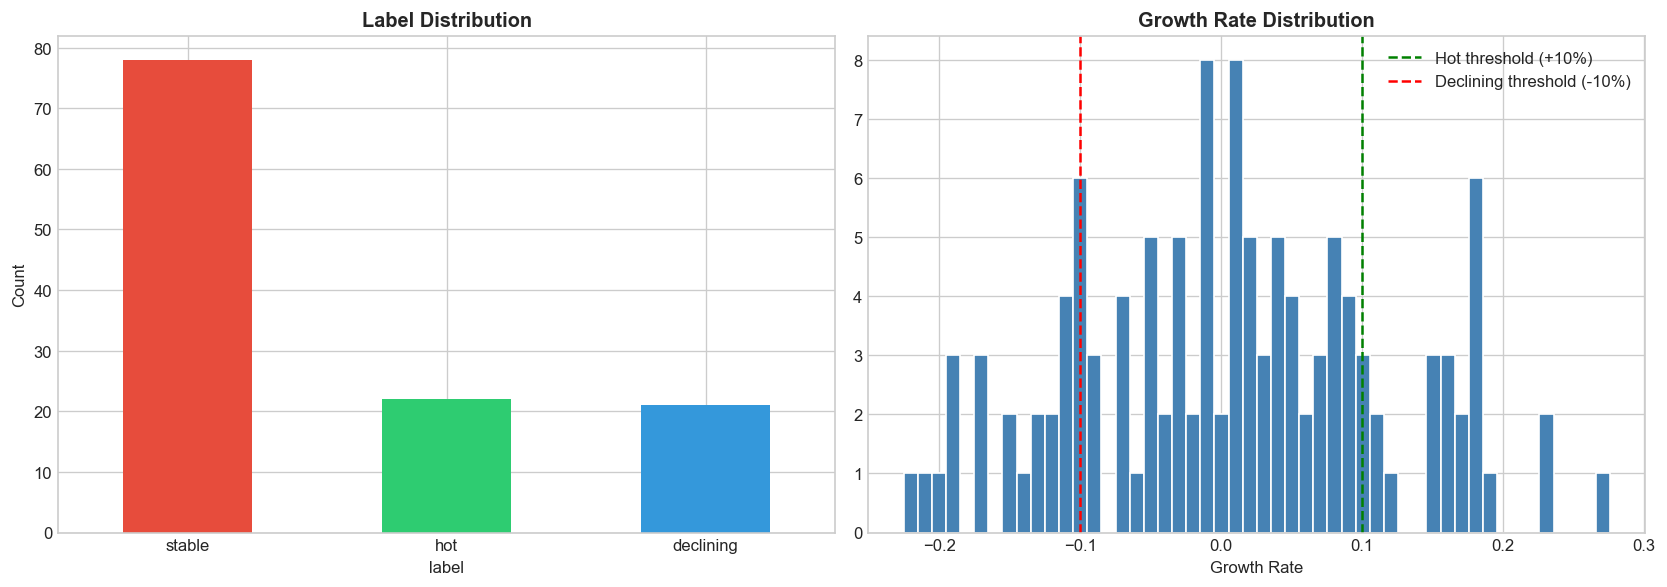

In [22]:
# Visualize label distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

labeled['label'].value_counts().plot(kind='bar', ax=axes[0], color=['#e74c3c', '#2ecc71', '#3498db'])
axes[0].set_title('Label Distribution', fontweight='bold')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=0)

labeled['actual_growth'].clip(-2, 2).hist(bins=50, ax=axes[1], color='steelblue', edgecolor='white')
axes[1].axvline(x=0.10, color='green', linestyle='--', label='Hot threshold (+10%)')
axes[1].axvline(x=-0.10, color='red', linestyle='--', label='Declining threshold (-10%)')
axes[1].set_title('Growth Rate Distribution', fontweight='bold')
axes[1].set_xlabel('Growth Rate')
axes[1].legend()

plt.tight_layout()
plt.savefig(FIG_DIR / '21_label_distribution.png', bbox_inches='tight')
plt.show()

## 4.6 Train/Validation/Test Split (Time-Series)

In [23]:
# Time-based split: train on earlier months, test on later months
all_months_sorted = sorted(labeled['month'].unique())
n_months = len(all_months_sorted)

# Reserve last 3 months for test, 3 before that for validation
test_months = all_months_sorted[-2:]   # last 2 months
val_months = all_months_sorted[-4:-2]   # 2 months before test
train_months = all_months_sorted[:-4]   # everything else

print(f'Total months: {n_months}')
print(f'Train months ({len(train_months)}): {train_months[0]} to {train_months[-1]}')
print(f'Val months ({len(val_months)}): {val_months[0]} to {val_months[-1]}')
print(f'Test months ({len(test_months)}): {test_months[0]} to {test_months[-1]}')

train_mask = labeled['month'].isin(train_months)
val_mask = labeled['month'].isin(val_months)
test_mask = labeled['month'].isin(test_months)

print(f'\nTrain: {train_mask.sum():,} rows')
print(f'Val:   {val_mask.sum():,} rows')
print(f'Test:  {test_mask.sum():,} rows')

Total months: 11
Train months (7): 2025-01 to 2025-07
Val months (2): 2025-08 to 2025-09
Test months (2): 2025-10 to 2025-11

Train: 77 rows
Val:   22 rows
Test:  22 rows


In [24]:
# Define feature columns (exclude target, metadata, and identifiers)
EXCLUDE_COLS = {
    'skill', 'month', 'label', 'actual_growth', 'next_month_count',
    'future_avg', 'current_baseline',
}

feature_cols = [c for c in labeled.columns if c not in EXCLUDE_COLS]
print(f'Feature columns ({len(feature_cols)}):')
for c in feature_cols:
    print(f'  {c}')

X_train = labeled.loc[train_mask, feature_cols].copy()
y_train = labeled.loc[train_mask, 'label'].copy()
y_train_growth = labeled.loc[train_mask, 'actual_growth'].copy()

X_val = labeled.loc[val_mask, feature_cols].copy()
y_val = labeled.loc[val_mask, 'label'].copy()
y_val_growth = labeled.loc[val_mask, 'actual_growth'].copy()

X_test = labeled.loc[test_mask, feature_cols].copy()
y_test = labeled.loc[test_mask, 'label'].copy()
y_test_growth = labeled.loc[test_mask, 'actual_growth'].copy()

# Replace infinities with NaN (HistGradientBoosting handles NaN natively)
for df in [X_train, X_val, X_test]:
    df.replace([np.inf, -np.inf], np.nan, inplace=True)

print(f'\nX_train shape: {X_train.shape}')
print(f'X_val shape:   {X_val.shape}')
print(f'X_test shape:  {X_test.shape}')

Feature columns (35):
  count
  avg_salary
  n_industries
  n_locations
  count_lag_1
  count_lag_2
  count_lag_3
  rolling_mean_3m
  rolling_mean_6m
  growth_rate_1m
  growth_rate_3m
  trend_slope
  month_of_year
  volatility_3m
  total_historical_count
  source_count
  industry_diversity
  location_diversity
  overall_avg_salary
  cooccurrence_degree
  emb_pca_0
  emb_pca_1
  emb_pca_2
  emb_pca_3
  emb_pca_4
  emb_pca_5
  emb_pca_6
  emb_pca_7
  emb_pca_8
  emb_pca_9
  emb_pca_10
  emb_pca_11
  emb_pca_12
  emb_pca_13
  emb_pca_14

X_train shape: (77, 35)
X_val shape:   (22, 35)
X_test shape:  (22, 35)


## 4.7 Baseline Models

In [25]:
def growth_to_label(growth):
    """Convert growth rate to label."""
    if growth > 0.10:
        return 'hot'
    elif growth < -0.10:
        return 'declining'
    else:
        return 'stable'

def evaluate_predictions(y_true, y_pred, name='Model'):
    """Compute and print evaluation metrics."""
    acc = accuracy_score(y_true, y_pred)
    f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)
    
    # Directional accuracy: hot/stable vs declining direction
    true_direction = y_true.map({'hot': 1, 'stable': 0, 'declining': -1})
    pred_direction = pd.Series(y_pred).map({'hot': 1, 'stable': 0, 'declining': -1})
    # Simple: is the sign the same?
    directional_acc = (true_direction.values == pred_direction.values).mean()
    
    print(f'\n{"=" * 50}')
    print(f'{name}')
    print(f'{"=" * 50}')
    print(f'Accuracy:             {acc:.3f}')
    print(f'Macro F1:             {f1_macro:.3f}')
    print(f'Directional Accuracy: {directional_acc:.3f}')
    
    return {'name': name, 'accuracy': acc, 'macro_f1': f1_macro, 'directional_acc': directional_acc}

In [26]:
baseline_results = []

# Baseline 1: Naive persistence (predict last month's trend continues)
# Use growth_rate_1m from test features as the prediction
naive_growth = X_test['growth_rate_1m'].fillna(0)
naive_preds = naive_growth.apply(growth_to_label)
baseline_results.append(evaluate_predictions(y_test, naive_preds.values, 'Baseline: Naive Persistence'))

# Baseline 2: Rolling average direction
# If rolling_mean_3m > rolling_mean_6m -> growing -> hot
rolling_diff = (X_test['rolling_mean_3m'].fillna(0) - X_test['rolling_mean_6m'].fillna(0))
rolling_growth = rolling_diff / X_test['rolling_mean_6m'].replace(0, 1).fillna(1)
rolling_preds = rolling_growth.apply(growth_to_label)
baseline_results.append(evaluate_predictions(y_test, rolling_preds.values, 'Baseline: Rolling Average'))

# Baseline 3: Always predict 'stable' (majority class baseline)
majority_class = y_train.value_counts().index[0]
majority_preds = [majority_class] * len(y_test)
baseline_results.append(evaluate_predictions(y_test, majority_preds, f'Baseline: Always "{majority_class}"'))


Baseline: Naive Persistence
Accuracy:             0.500
Macro F1:             0.444
Directional Accuracy: 0.500

Baseline: Rolling Average
Accuracy:             0.545
Macro F1:             0.353
Directional Accuracy: 0.545

Baseline: Always "stable"
Accuracy:             0.545
Macro F1:             0.353
Directional Accuracy: 0.545


## 4.8 Gradient Boosting Classifier

In [27]:
# Train classifier
print('Training HistGradientBoostingClassifier...')

clf = HistGradientBoostingClassifier(
    max_iter=300,
    max_depth=6,
    learning_rate=0.05,
    min_samples_leaf=10,
    class_weight='balanced',
    random_state=42,
    categorical_features=None,
)

clf.fit(X_train, y_train)

# Predictions on validation set
val_preds = clf.predict(X_val)
val_result = evaluate_predictions(y_val, val_preds, 'GBM Classifier (Validation)')
print(f'\nDetailed classification report (Validation):')
print(classification_report(y_val, val_preds, zero_division=0))

# Predictions on test set
test_preds = clf.predict(X_test)
test_result = evaluate_predictions(y_test, test_preds, 'GBM Classifier (Test)')
print(f'\nDetailed classification report (Test):')
print(classification_report(y_test, test_preds, zero_division=0))

Training HistGradientBoostingClassifier...

GBM Classifier (Validation)
Accuracy:             0.636
Macro F1:             0.374
Directional Accuracy: 0.636

Detailed classification report (Validation):
              precision    recall  f1-score   support

   declining       1.00      0.20      0.33         5
         hot       0.00      0.00      0.00         2
      stable       0.72      0.87      0.79        15

    accuracy                           0.64        22
   macro avg       0.57      0.36      0.37        22
weighted avg       0.72      0.64      0.61        22


GBM Classifier (Test)
Accuracy:             0.500
Macro F1:             0.222
Directional Accuracy: 0.500

Detailed classification report (Test):
              precision    recall  f1-score   support

   declining       0.00      0.00      0.00         0
         hot       0.00      0.00      0.00        10
      stable       0.52      0.92      0.67        12

    accuracy                           0.50        2

In [28]:
# Also train a regressor for continuous growth rate prediction (for ranking)
print('Training HistGradientBoostingRegressor...')

reg = HistGradientBoostingRegressor(
    max_iter=300,
    max_depth=6,
    learning_rate=0.05,
    min_samples_leaf=10,
    random_state=42,
)

# Clip extreme growth values for training stability
y_train_growth_clipped = y_train_growth.clip(-2, 2)
reg.fit(X_train, y_train_growth_clipped)

# Evaluate
val_growth_pred = reg.predict(X_val)
test_growth_pred = reg.predict(X_test)

val_rmse = np.sqrt(mean_squared_error(y_val_growth.clip(-2, 2), val_growth_pred))
test_rmse = np.sqrt(mean_squared_error(y_test_growth.clip(-2, 2), test_growth_pred))

print(f'Regressor RMSE (val):  {val_rmse:.4f}')
print(f'Regressor RMSE (test): {test_rmse:.4f}')

# Convert regression predictions to labels for comparison
reg_test_labels = pd.Series(test_growth_pred).apply(growth_to_label).values
reg_result = evaluate_predictions(y_test, reg_test_labels, 'GBM Regressor -> Labels (Test)')

Training HistGradientBoostingRegressor...
Regressor RMSE (val):  0.1321
Regressor RMSE (test): 0.0989

GBM Regressor -> Labels (Test)
Accuracy:             0.545
Macro F1:             0.362
Directional Accuracy: 0.545


## 4.9 Model Evaluation & Visualization

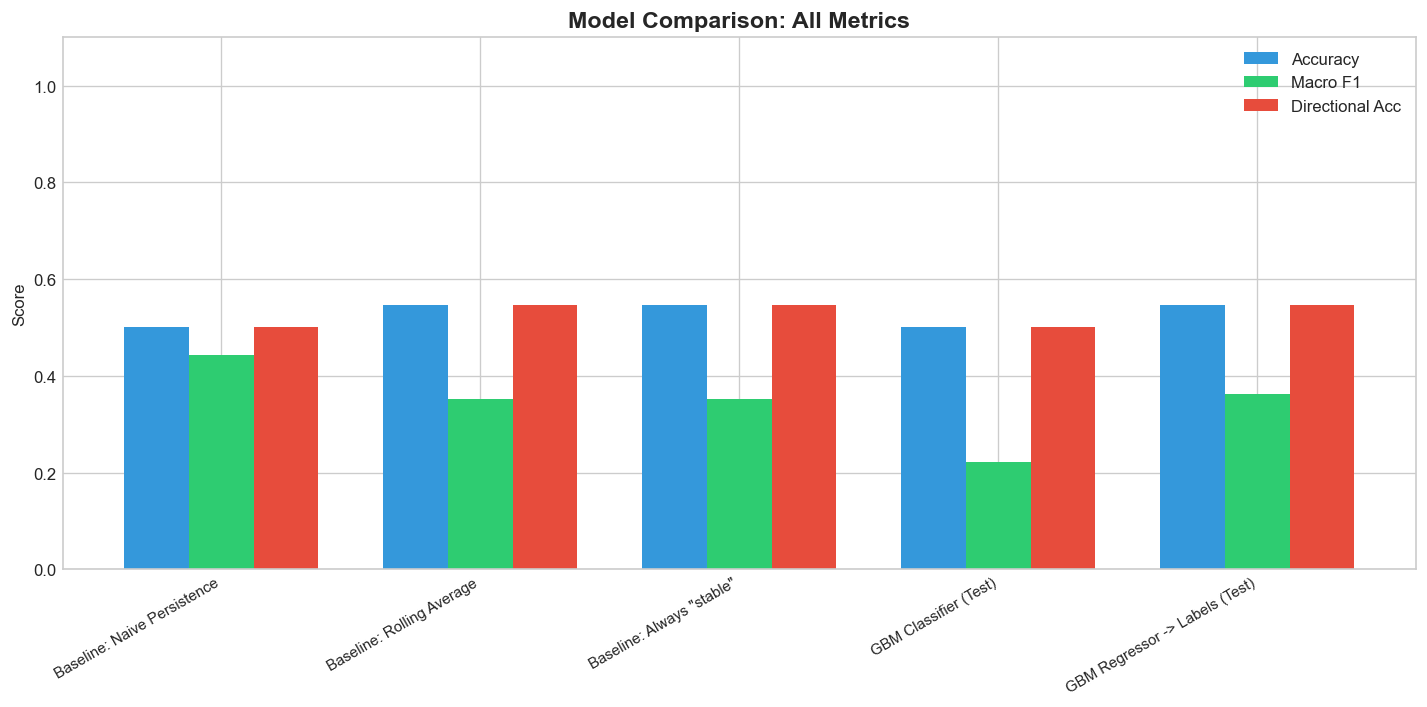

,name,accuracy,macro_f1,directional_acc
0,Baseline: Naive Persistence,0.500000,0.443678,0.500000
1,Baseline: Rolling Average,0.545455,0.352941,0.545455
2,"Baseline: Always ""stable""",0.545455,0.352941,0.545455
3,GBM Classifier (Test),0.500000,0.222222,0.500000
4,GBM Regressor -> Labels (Test),0.545455,0.361991,0.545455


In [29]:
# Compare all models
all_results = baseline_results + [test_result, reg_result]
results_df = pd.DataFrame(all_results)

fig, ax = plt.subplots(figsize=(12, 6))
x = range(len(results_df))
width = 0.25

bars1 = ax.bar([i - width for i in x], results_df['accuracy'], width, label='Accuracy', color='#3498db')
bars2 = ax.bar(x, results_df['macro_f1'], width, label='Macro F1', color='#2ecc71')
bars3 = ax.bar([i + width for i in x], results_df['directional_acc'], width, label='Directional Acc', color='#e74c3c')

ax.set_title('Model Comparison: All Metrics', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(results_df['name'], rotation=30, ha='right', fontsize=9)
ax.set_ylim(0, 1.1)
ax.legend()
ax.set_ylabel('Score')

plt.tight_layout()
plt.savefig(FIG_DIR / '22_model_comparison.png', bbox_inches='tight')
plt.show()

display(results_df)

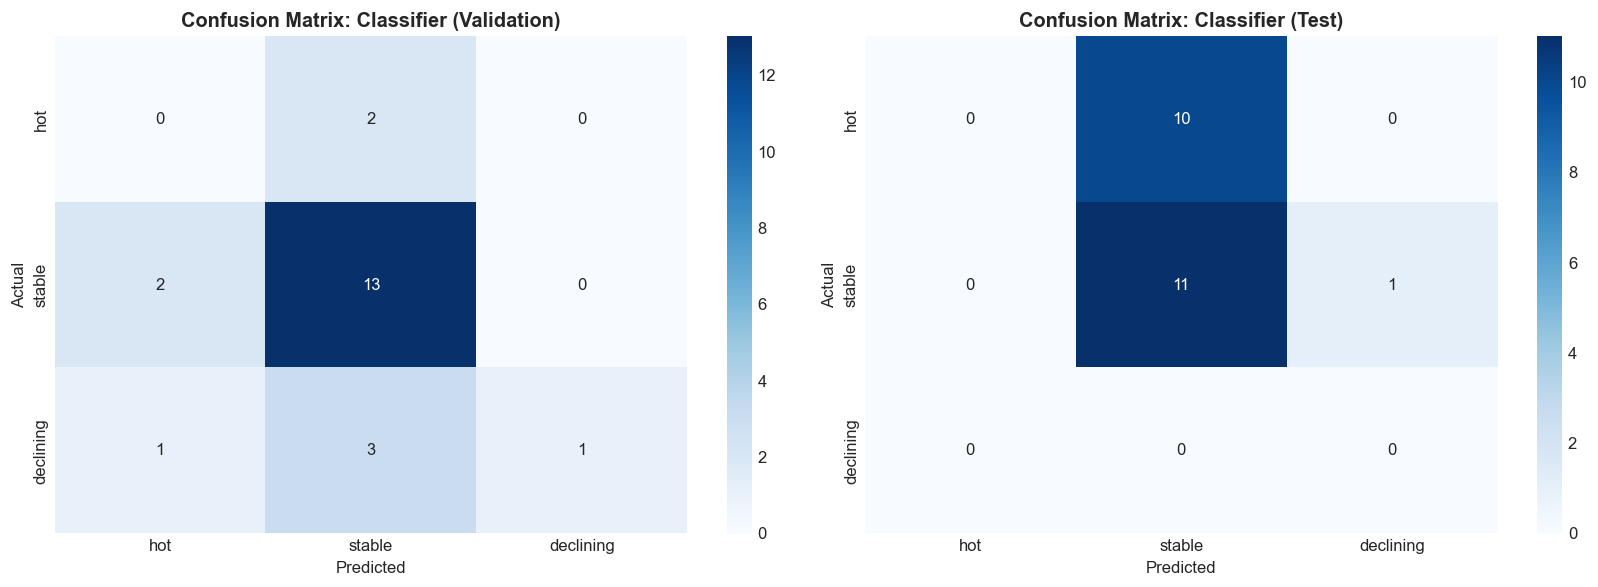

In [30]:
# Confusion Matrix
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

labels_order = ['hot', 'stable', 'declining']

for ax, preds, title in [
    (axes[0], clf.predict(X_val), 'Classifier (Validation)'),
    (axes[1], clf.predict(X_test), 'Classifier (Test)'),
]:
    y_true = y_val if 'Val' in title else y_test
    cm = confusion_matrix(y_true, preds, labels=labels_order)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=labels_order, yticklabels=labels_order)
    ax.set_title(f'Confusion Matrix: {title}', fontweight='bold')
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')

plt.tight_layout()
plt.savefig(FIG_DIR / '23_confusion_matrix.png', bbox_inches='tight')
plt.show()

In [31]:
# Feature Importance
if hasattr(clf, 'feature_importances_'):
    importance = pd.Series(clf.feature_importances_, index=feature_cols)
    top15 = importance.nlargest(15)
    
    fig, ax = plt.subplots(figsize=(10, 7))
    top15.iloc[::-1].plot(kind='barh', ax=ax, color=sns.color_palette('viridis', 15))
    ax.set_title('Top 15 Feature Importances (Classifier)', fontsize=14, fontweight='bold')
    ax.set_xlabel('Importance')
    plt.tight_layout()
    plt.savefig(FIG_DIR / '24_feature_importance.png', bbox_inches='tight')
    plt.show()
else:
    print('Feature importances not available')

Feature importances not available


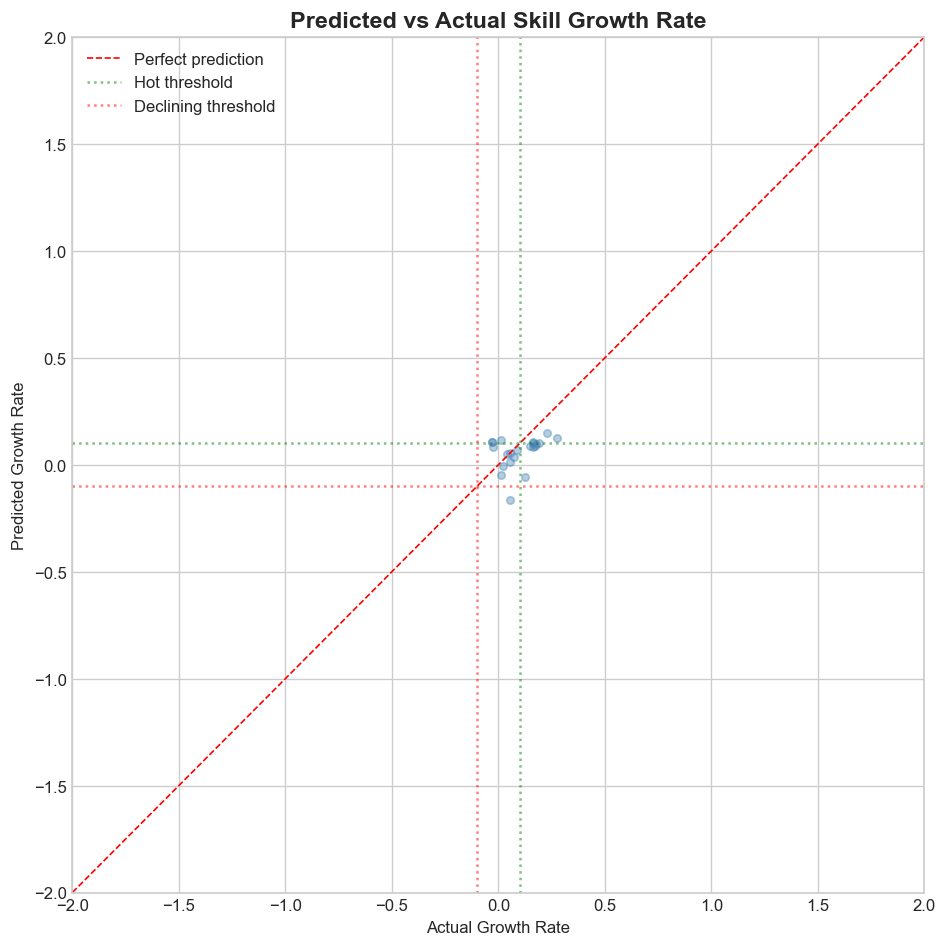

In [32]:
# Predicted vs Actual Growth Rate (Regressor)
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(y_test_growth.clip(-2, 2), test_growth_pred, alpha=0.4, s=20, color='steelblue')
ax.plot([-2, 2], [-2, 2], 'r--', linewidth=1, label='Perfect prediction')
ax.axhline(y=0.10, color='green', linestyle=':', alpha=0.5, label='Hot threshold')
ax.axhline(y=-0.10, color='red', linestyle=':', alpha=0.5, label='Declining threshold')
ax.axvline(x=0.10, color='green', linestyle=':', alpha=0.5)
ax.axvline(x=-0.10, color='red', linestyle=':', alpha=0.5)
ax.set_xlabel('Actual Growth Rate')
ax.set_ylabel('Predicted Growth Rate')
ax.set_title('Predicted vs Actual Skill Growth Rate', fontsize=14, fontweight='bold')
ax.legend()
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
plt.tight_layout()
plt.savefig(FIG_DIR / '25_predicted_vs_actual_growth.png', bbox_inches='tight')
plt.show()

## 4.10 Cold-Start Strategy for New Skills

In [33]:
from sklearn.metrics.pairwise import cosine_similarity

# Skills that HAVE predictions (from the model)
predicted_skills = set(labeled[labeled['month'].isin(test_months)]['skill'].unique())

# Skills that DON'T have enough temporal data (cold-start)
all_taxonomy_skills = set(df_taxonomy['skill_name'])
cold_start_skills = all_taxonomy_skills - set(valid_skills)

print(f'Skills with model predictions: {len(predicted_skills)}')
print(f'Cold-start skills (no temporal data): {len(cold_start_skills)}')

# For cold-start skills, find similar skills that have predictions
# and use their weighted average trend
def predict_cold_start(skill_name, embeddings_df, predicted_results, top_k=5):
    """Predict trend for a cold-start skill using embedding similarity."""
    if skill_name not in embeddings_df.index:
        return {'predicted_trend': 'stable', 'confidence': 0.0, 'growth_rate_pred': 0.0}
    
    skill_emb = embeddings_df.loc[skill_name].values.reshape(1, -1)
    
    # Compare to all predicted skills
    predicted_skill_names = list(predicted_results.keys())
    if not predicted_skill_names:
        return {'predicted_trend': 'stable', 'confidence': 0.0, 'growth_rate_pred': 0.0}
    
    pred_embs = embeddings_df.loc[
        [s for s in predicted_skill_names if s in embeddings_df.index]
    ].values
    pred_names = [s for s in predicted_skill_names if s in embeddings_df.index]
    
    if len(pred_embs) == 0:
        return {'predicted_trend': 'stable', 'confidence': 0.0, 'growth_rate_pred': 0.0}
    
    similarities = cosine_similarity(skill_emb, pred_embs)[0]
    top_indices = np.argsort(similarities)[-top_k:]
    
    # Weighted average of similar skills' predictions
    weights = similarities[top_indices]
    weights = np.maximum(weights, 0)  # no negative weights
    weight_sum = weights.sum()
    
    if weight_sum == 0:
        return {'predicted_trend': 'stable', 'confidence': 0.0, 'growth_rate_pred': 0.0}
    
    weighted_growth = sum(
        weights[i] * predicted_results[pred_names[idx]]['growth_rate_pred']
        for i, idx in enumerate(top_indices)
    ) / weight_sum
    
    avg_confidence = weights.mean()
    label = growth_to_label(weighted_growth)
    
    return {
        'predicted_trend': label,
        'confidence': float(avg_confidence),
        'growth_rate_pred': float(weighted_growth),
        'similar_skills': [pred_names[idx] for idx in top_indices],
    }

print('Cold-start prediction function ready')

Skills with model predictions: 11
Cold-start skills (no temporal data): 1487
Cold-start prediction function ready


## 4.11 Generate Final Predictions for All Skills

In [34]:
# Get the latest month's features for each skill (most recent data)
latest_features = (
    monthly_features
    .sort_values('month')
    .groupby('skill')
    .tail(1)
    .copy()
)

print(f'Skills with latest features: {len(latest_features)}')

# Predict for all skills with temporal data
X_latest = latest_features[feature_cols].copy()
X_latest.replace([np.inf, -np.inf], np.nan, inplace=True)

latest_features['predicted_trend'] = clf.predict(X_latest)
latest_features['growth_rate_pred'] = reg.predict(X_latest)

# Get prediction probabilities for confidence
proba = clf.predict_proba(X_latest)
latest_features['confidence'] = proba.max(axis=1)

# Store predictions for model-predicted skills
model_predictions = {}
for _, row in latest_features.iterrows():
    model_predictions[row['skill']] = {
        'predicted_trend': row['predicted_trend'],
        'confidence': float(row['confidence']),
        'growth_rate_pred': float(row['growth_rate_pred']),
        'current_demand': int(row['count']),
        'method': 'model',
    }

print(f'Model predictions: {len(model_predictions)}')
print(f'Trend distribution: {Counter(r["predicted_trend"] for r in model_predictions.values())}')

Skills with latest features: 11
Model predictions: 11
Trend distribution: Counter({'stable': 11})


In [35]:
# Predict cold-start skills via embedding similarity
cold_start_predictions = {}
for skill in cold_start_skills:
    result = predict_cold_start(skill, df_embeddings, model_predictions)
    result['current_demand'] = int(df_taxonomy[df_taxonomy['skill_name'] == skill]['total_count'].values[0])
    result['method'] = 'cold_start'
    cold_start_predictions[skill] = result

print(f'Cold-start predictions: {len(cold_start_predictions)}')
print(f'Trend distribution: {Counter(r["predicted_trend"] for r in cold_start_predictions.values())}')

# Combine all predictions
all_predictions = {**model_predictions, **cold_start_predictions}
print(f'\nTotal predictions: {len(all_predictions)} / {len(df_taxonomy)} skills')

Cold-start predictions: 1487
Trend distribution: Counter({'stable': 1487})

Total predictions: 1498 / 1498 skills


In [36]:
# Create predictions DataFrame
pred_rows = []
for skill_name, result in all_predictions.items():
    pred_rows.append({
        'skill_name': skill_name,
        'predicted_trend': result['predicted_trend'],
        'confidence': result['confidence'],
        'growth_rate_pred': result['growth_rate_pred'],
        'current_demand': result.get('current_demand', 0),
        'method': result['method'],
    })

df_predictions = pd.DataFrame(pred_rows).sort_values('growth_rate_pred', ascending=False)

print(f'Predictions DataFrame: {df_predictions.shape}')
print(f'\nOverall trend distribution:')
print(df_predictions['predicted_trend'].value_counts())
print(f'\nBy prediction method:')
print(df_predictions.groupby('method')['predicted_trend'].value_counts())

Predictions DataFrame: (1498, 6)

Overall trend distribution:
predicted_trend
stable    1498
Name: count, dtype: int64

By prediction method:
method      predicted_trend
cold_start  stable             1487
model       stable               11
Name: count, dtype: int64


In [37]:
# Show top predicted HOT skills
print('\nTOP 20 PREDICTED HOT SKILLS (highest growth rate):')
print('=' * 70)
hot_skills = df_predictions[
    df_predictions['predicted_trend'] == 'hot'
].sort_values('growth_rate_pred', ascending=False).head(20)

for i, (_, row) in enumerate(hot_skills.iterrows(), 1):
    method_tag = '[MODEL]' if row['method'] == 'model' else '[COLD-START]'
    print(f'{i:3d}. {row["skill_name"]:35s} growth: {row["growth_rate_pred"]:+.2%}  '
          f'conf: {row["confidence"]:.2f}  demand: {row["current_demand"]:>6,}  {method_tag}')


TOP 20 PREDICTED HOT SKILLS (highest growth rate):


In [38]:
# Show top predicted DECLINING skills
print('\nTOP 15 PREDICTED DECLINING SKILLS:')
print('=' * 70)
declining_skills = df_predictions[
    df_predictions['predicted_trend'] == 'declining'
].sort_values('growth_rate_pred').head(15)

for i, (_, row) in enumerate(declining_skills.iterrows(), 1):
    method_tag = '[MODEL]' if row['method'] == 'model' else '[COLD-START]'
    print(f'{i:3d}. {row["skill_name"]:35s} growth: {row["growth_rate_pred"]:+.2%}  '
          f'conf: {row["confidence"]:.2f}  demand: {row["current_demand"]:>6,}  {method_tag}')


TOP 15 PREDICTED DECLINING SKILLS:


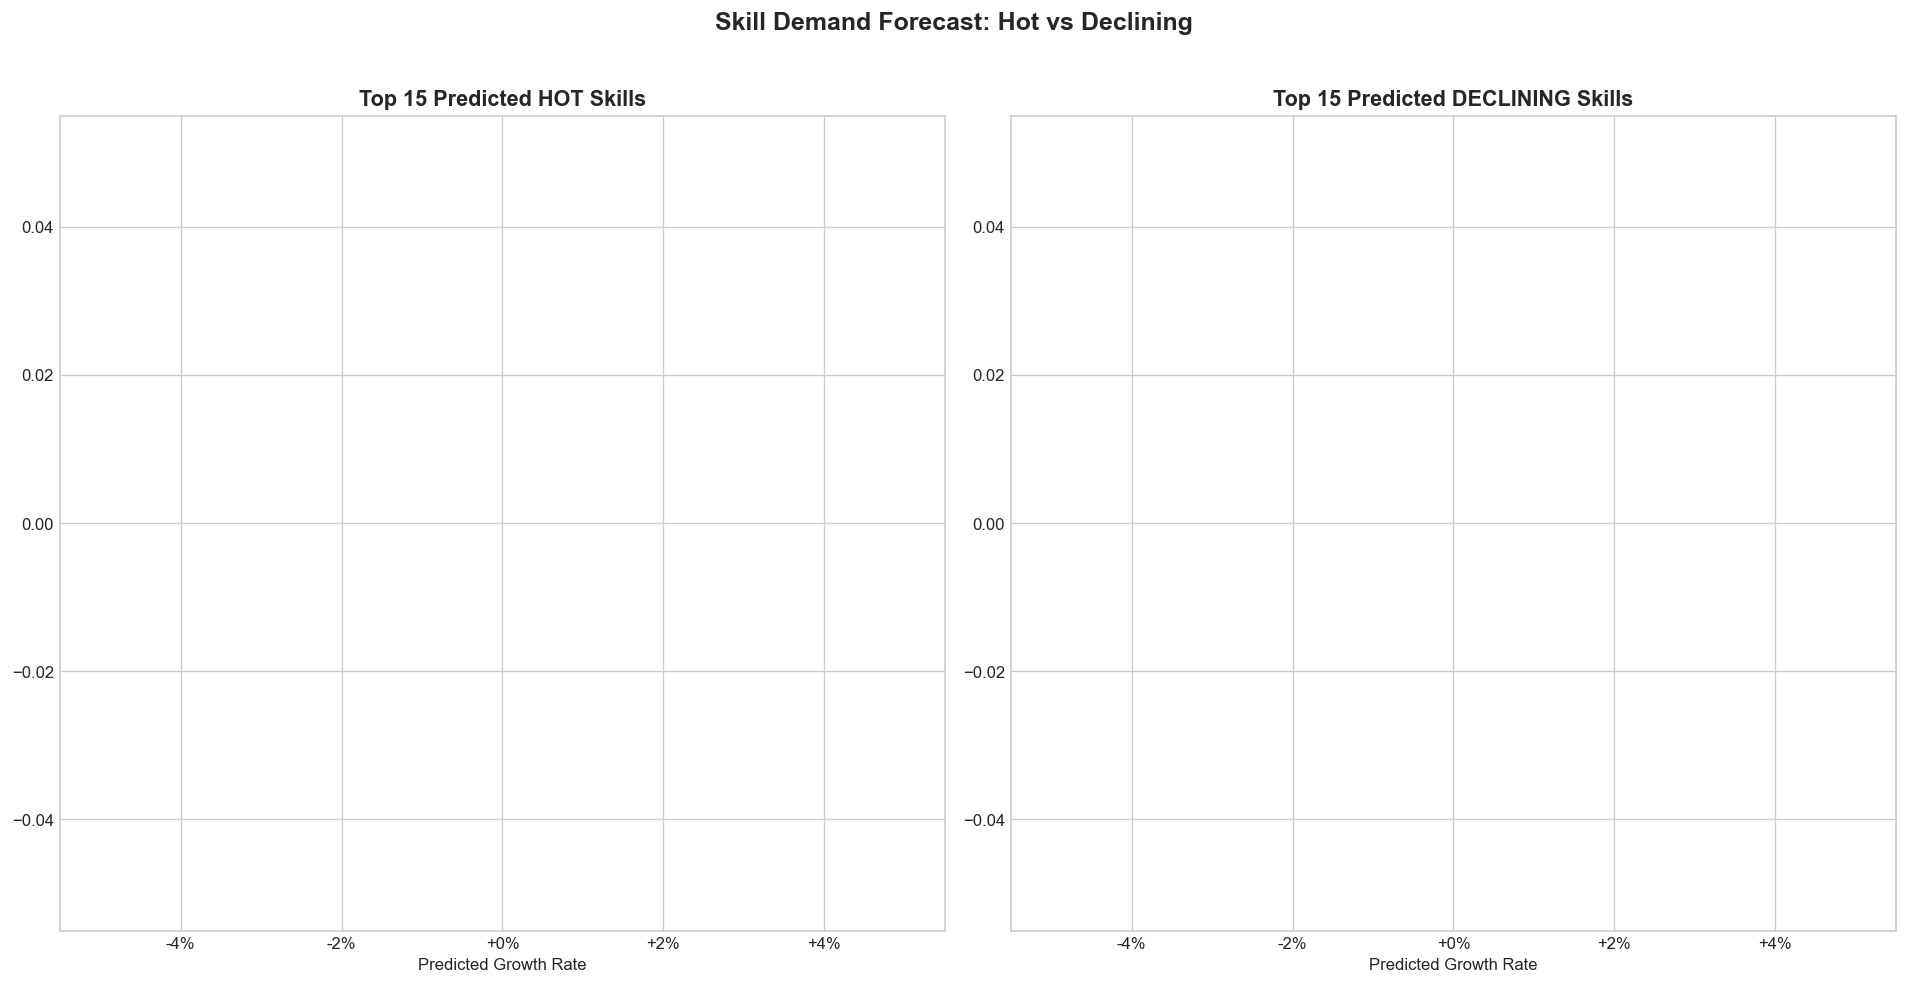

In [39]:
# Visualization: Top Hot vs Top Declining Skills
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Hot skills
top_hot = df_predictions[df_predictions['predicted_trend'] == 'hot'].nlargest(15, 'growth_rate_pred')
axes[0].barh(top_hot['skill_name'].iloc[::-1], top_hot['growth_rate_pred'].iloc[::-1], color='#2ecc71')
axes[0].set_title('Top 15 Predicted HOT Skills', fontweight='bold', fontsize=13)
axes[0].set_xlabel('Predicted Growth Rate')
axes[0].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:+.0%}'))

# Declining skills
top_decline = df_predictions[df_predictions['predicted_trend'] == 'declining'].nsmallest(15, 'growth_rate_pred')
axes[1].barh(top_decline['skill_name'].iloc[::-1], top_decline['growth_rate_pred'].iloc[::-1], color='#e74c3c')
axes[1].set_title('Top 15 Predicted DECLINING Skills', fontweight='bold', fontsize=13)
axes[1].set_xlabel('Predicted Growth Rate')
axes[1].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:+.0%}'))

plt.suptitle('Skill Demand Forecast: Hot vs Declining', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(FIG_DIR / '26_hot_vs_declining_skills.png', bbox_inches='tight')
plt.show()

## 4.12 Save Model Artifacts & Predictions

In [40]:
# Save trained models
joblib.dump(clf, PROCESS_DIR / 'skill_demand_classifier.joblib')
joblib.dump(reg, PROCESS_DIR / 'skill_demand_regressor.joblib')
joblib.dump(pca, PROCESS_DIR / 'skill_embedding_pca.joblib')
print('Saved: skill_demand_classifier.joblib')
print('Saved: skill_demand_regressor.joblib')
print('Saved: skill_embedding_pca.joblib')

# Save feature matrix (for debugging / retraining)
monthly_features.to_parquet(PROCESS_DIR / 'skill_demand_features.parquet', index=False)
print(f'Saved: skill_demand_features.parquet ({len(monthly_features):,} rows)')

# Save predictions
df_predictions.to_parquet(PROCESS_DIR / 'skill_demand_predictions.parquet', index=False)
print(f'Saved: skill_demand_predictions.parquet ({len(df_predictions):,} skills)')

# Also save as JSON for easy backend consumption
predictions_json = df_predictions.to_dict(orient='records')
with open(PROCESS_DIR / 'skill_demand_predictions.json', 'w') as f:
    json.dump(predictions_json, f, indent=2, default=str)
print(f'Saved: skill_demand_predictions.json')

# Save model metadata
model_meta = {
    'model_type': 'HistGradientBoostingClassifier',
    'feature_columns': feature_cols,
    'n_features': len(feature_cols),
    'n_skills_with_model': len(model_predictions),
    'n_skills_cold_start': len(cold_start_predictions),
    'n_skills_total': len(all_predictions),
    'train_months': [str(m) for m in train_months],
    'test_months': [str(m) for m in test_months],
    'test_accuracy': float(test_result['accuracy']),
    'test_macro_f1': float(test_result['macro_f1']),
    'test_directional_accuracy': float(test_result['directional_acc']),
    'embedding_model': 'all-MiniLM-L6-v2',
    'embedding_dims': 384,
    'pca_dims': N_EMBEDDING_DIMS,
}
with open(PROCESS_DIR / 'skill_demand_model_meta.json', 'w') as f:
    json.dump(model_meta, f, indent=2)
print('Saved: skill_demand_model_meta.json')

Saved: skill_demand_classifier.joblib
Saved: skill_demand_regressor.joblib
Saved: skill_embedding_pca.joblib
Saved: skill_demand_features.parquet (132 rows)
Saved: skill_demand_predictions.parquet (1,498 skills)
Saved: skill_demand_predictions.json
Saved: skill_demand_model_meta.json


In [41]:
# Final summary
print('\n' + '=' * 70)
print('SKILL DEMAND PREDICTION MODEL - SUMMARY')
print('=' * 70)
print(f'\nModel: HistGradientBoostingClassifier')
print(f'Features: {len(feature_cols)} ({len(feature_cols) - N_EMBEDDING_DIMS} engineered + {N_EMBEDDING_DIMS} embedding PCA)')
print(f'\nTest Performance:')
print(f'  Accuracy:             {test_result["accuracy"]:.3f}')
print(f'  Macro F1:             {test_result["macro_f1"]:.3f}')
print(f'  Directional Accuracy: {test_result["directional_acc"]:.3f}')
print(f'\nPredictions:')
print(f'  Model-based:  {len(model_predictions):,} skills (>= {MIN_MONTHS} months of data)')
print(f'  Cold-start:   {len(cold_start_predictions):,} skills (embedding similarity)')
print(f'  Total:        {len(all_predictions):,} / {len(df_taxonomy)} skills')
print(f'\nTrend distribution:')
for trend, count in df_predictions['predicted_trend'].value_counts().items():
    pct = count / len(df_predictions) * 100
    print(f'  {trend:12s}: {count:5d} ({pct:.1f}%)')

print(f'\nOutput files in {PROCESS_DIR}:')
for f in sorted(PROCESS_DIR.glob('skill_demand_*')):
    size = f.stat().st_size
    unit = 'KB' if size < 1024**2 else 'MB'
    size_val = size / 1024 if unit == 'KB' else size / 1024**2
    print(f'  {f.name:45s} {size_val:.1f} {unit}')


SKILL DEMAND PREDICTION MODEL - SUMMARY

Model: HistGradientBoostingClassifier
Features: 35 (20 engineered + 15 embedding PCA)

Test Performance:
  Accuracy:             0.500
  Macro F1:             0.222
  Directional Accuracy: 0.500

Predictions:
  Model-based:  11 skills (>= 3 months of data)
  Cold-start:   1,487 skills (embedding similarity)
  Total:        1,498 / 1498 skills

Trend distribution:
  stable      :  1498 (100.0%)

Output files in ../data/process:
  skill_demand_classifier.joblib                652.0 KB
  skill_demand_features.parquet                 34.6 KB
  skill_demand_model_meta.json                  1.2 KB
  skill_demand_predictions.json                 319.2 KB
  skill_demand_predictions.parquet              45.8 KB
  skill_demand_regressor.joblib                 259.8 KB
